In [1]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.api.types import CategoricalDtype
from sklearn import linear_model
from sklearn.metrics import RocCurveDisplay, auc, mean_squared_error, roc_curve
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.utils.fixes import loguniform

from label_flip_revised.utils import create_dir

In [2]:
PATH_ROOT = os.path.join(Path().absolute().parent)
print(PATH_ROOT)

/home/lukec/workspace/diva_01


In [3]:
path_output = os.path.join(PATH_ROOT, 'results_plot')
print(path_output)
create_dir(path_output)

/home/lukec/workspace/diva_01/results_plot


In [4]:
df = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth_noisy', 'synth_falfa_nn_db.csv'))
print(df.shape)

(4050, 38)


In [5]:
noise_rate = df['Data'].apply(lambda x: float(x.split('_')[6][2:]))
df['Noise.Rate'] = noise_rate

for nr in noise_rate.unique():
    assert len(noise_rate[noise_rate == nr]) == 50 * 9

In [6]:
# Remove noise rate from Data.Base
df['Data.Base'] = df['Data.Base'].apply(lambda x: '_'.join(list(np.delete(x.split('_'), -2))))


In [7]:
print(df.columns)

Index(['Data', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
       'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
       'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
       'Path.Train', 'Path.Poison', 'Path.Test', 'Rate', 'Train.Clean',
       'Test.Clean', 'Train.Poison', 'Test.Poison', 'Data.Base', 'Noise.Rate'],
      dtype='object')


In [8]:
COLS_CM = [
    'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
    'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
    'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
]
COL_Y = 'Test.Poison'

print(len(COLS_CM))

28


In [9]:
N_ITER_SEARCH = 100

# Find parameter
param = {'alpha': loguniform(1e-4, 10),}
X = df[COLS_CM]
y = df[COL_Y]
regressor = linear_model.Ridge()
param_search = RandomizedSearchCV(regressor, param_distributions=param, n_iter=N_ITER_SEARCH, n_jobs=-1)
param_search.fit(X, y)

best_estimator_ = param_search.best_estimator_.get_params()
alpha = np.round(best_estimator_['alpha'], 4)
print(alpha)

0.0077


In [10]:
df['Data.Base'].nunique()

50

In [11]:
N_FOLD = 5
# Train on datasets that below this noise threshold
NOISE_THRESHOLD = 0.0


df['Prediction'] = 0.

# Split by clean data
idx_clean = df[(df['Rate'] == 0) & (df['Noise.Rate'] == 0)].index
kf = KFold(n_splits=N_FOLD, shuffle=True)
counter = 0
for i_train, i_test in kf.split(idx_clean):
    idx_train_clean = idx_clean[i_train]
    idx_test_clean = idx_clean[i_test]

    data_train = df.loc[idx_train_clean, 'Data.Base']
    data_test = df.loc[idx_test_clean, 'Data.Base']

    df_noise_threshold = df[df['Noise.Rate'] <= NOISE_THRESHOLD]
    idx_train = df_noise_threshold[df_noise_threshold['Data.Base'].isin(data_train)].index

    idx_test = df[df['Data.Base'].isin(data_test)].index
    counter += len(idx_test)

    X_train = df.loc[idx_train, COLS_CM]
    y_train = df.loc[idx_train, COL_Y]
    X_test = df.loc[idx_test, COLS_CM]
    y_test = df.loc[idx_test, COL_Y]

    regressor = linear_model.Ridge(alpha=alpha)
    regressor.fit(X_train, y_train)

    df.loc[idx_test, 'Prediction'] = regressor.predict(X_test)
assert counter == df.shape[0], f'{counter} != {df.shape[0]}'

# Apply clipping
df['Prediction'] = np.amin([df['Prediction'].to_numpy(), np.ones(df.shape[0])], axis=0)

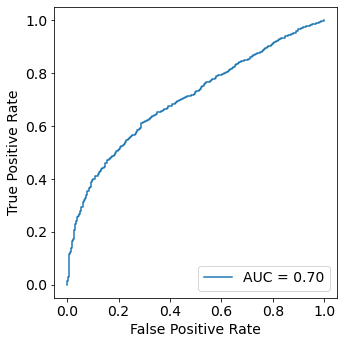

In [12]:
THRESHOLD = 0.0

FONTSIZE = 14
FIGSIZE = (5, 5)

plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
y_true_ = (df['Rate'] > THRESHOLD).astype(int)
y_score_ = df['Train.Poison'] - df['Prediction']
fpr, tpr, thresholds = roc_curve(y_true_, y_score_)
roc_auc_ = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_).plot(ax=ax)
plt.tight_layout()
plt.show()

In [13]:
df_ = df[(df['Rate'] == 0) & (df['Noise.Rate'] == 0)]
dif_00 = (df_['Train.Poison'] - df_['Prediction'])
print(dif_00.min(), dif_00.max())

threshold = np.quantile(dif_00, 0.95)

print(f'threshold: {threshold}')

-0.007074249419726786 0.40198535285838277
threshold: 0.3466505793963151


In [14]:
df[(df['Rate'] == 0) & (df['Noise.Rate'] == 0)].shape[0]

50

In [15]:
results = (df['Train.Poison'] - df['Prediction']) > threshold
df_ = df[['Noise.Rate', 'Rate']].copy()
df_['Prediction'] = results.astype(int)
df_ = df_.rename(columns = {'Noise.Rate':'Noise Label Rate', 'Rate':'Poisoning Rate', 'Prediction': 'FPR'})
df_grouped = df_.groupby(['Noise Label Rate', 'Poisoning Rate']).sum()
df_grouped = df_grouped.reset_index()
df_pivot = df_grouped.pivot('Poisoning Rate', 'Noise Label Rate', 'FPR')
df_pivot

Noise Label Rate,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40
Poisoning Rate,,,,,,,,,
0.00,3,6,11,14,18,20,27,29,29
0.05,8,14,13,18,24,30,28,32,26
0.10,19,22,24,28,30,29,28,31,33
0.15,19,26,29,34,36,33,31,35,35
0.20,28,32,28,35,33,35,35,33,34
0.25,27,33,34,35,35,38,38,38,36
0.30,32,37,37,38,38,40,36,41,36
0.35,32,37,35,35,40,38,40,38,37
0.40,33,35,41,38,40,36,41,39,36


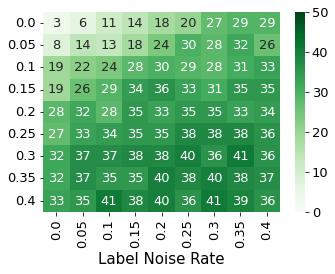

In [16]:
FONTSIZE = 13
FIGSIZE = (5, 4)

plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.heatmap(df_pivot, ax=ax, annot=True, fmt='d', cmap="Greens", vmin=0, vmax=50)
plt.yticks(rotation=0)
plt.xlabel('Label Noise Rate', fontsize=FONTSIZE+2)
# plt.ylabel('Poisoning Rate', fontsize=FONTSIZE+2)
plt.ylabel('')
plt.tight_layout()
plot_output = os.path.join(path_output, 'synth_heatmap_noise.svg')
plt.savefig(plot_output, dpi=300)